# Tutorial

`micromodelsim` enables the simulation of diffusion-weighted NMR measurements using microstructural models. This minimal tutorial covers the basic functionality.

Let's start by importing the required packages.


In [7]:
import os

import healpy as hp
import nibabel as nib
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt

import micromodelsim as mmsim

## Gradients

Gradient information is stored in a `Gradient` object.

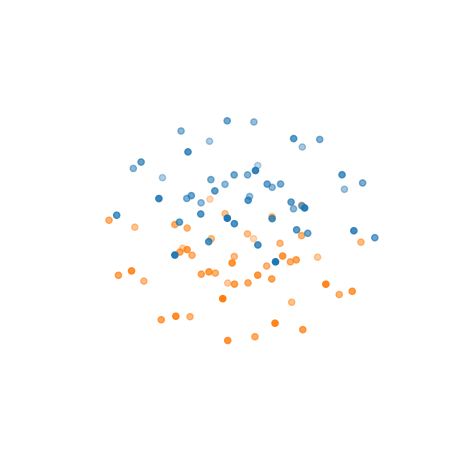

In [3]:
bvecs = np.array(
    [
        [0.283, 0.283, 0.917],
        [-0.283, 0.283, 0.917],
        [-0.283, -0.283, 0.917],
        [0.283, -0.283, 0.917],
        [0.689, 0.285, 0.667],
        [0.285, 0.689, 0.667],
        [-0.285, 0.689, 0.667],
        [-0.689, 0.285, 0.667],
        [-0.689, -0.285, 0.667],
        [-0.285, -0.689, 0.667],
        [0.285, -0.689, 0.667],
        [0.689, -0.285, 0.667],
        [0.943, 0.0, 0.333],
        [0.667, 0.667, 0.333],
        [0.0, 0.943, 0.333],
        [-0.667, 0.667, 0.333],
        [-0.943, 0.0, 0.333],
        [-0.667, -0.667, 0.333],
        [-0.0, -0.943, 0.333],
        [0.667, -0.667, 0.333],
        [0.924, 0.383, 0.0],
        [0.383, 0.924, 0.0],
        [-0.383, 0.924, 0.0],
        [-0.924, 0.383, 0.0],
    ]
)

bvals = np.concatenate((np.ones(len(bvecs)), 2 * np.ones(len(bvecs))))

bvecs = np.vstack((bvecs, bvecs))

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(bvals * bvecs[:, 0], bvals * bvecs[:, 1], bvals * bvecs[:, 2])
ax.scatter(-bvals * bvecs[:, 0], -bvals * bvecs[:, 1], -bvals * bvecs[:, 2])
ax.set_axis_off()
fig.tight_layout()
plt.show()

gradient = mmsim.Gradient(bvals, bvecs)

## ODFs

Orientation distribution functions are represented in the spherical harmonics domain with $l_\text{max} = 8$ and with indexing $i = \frac{1}{2}l(l + 1) + m$.

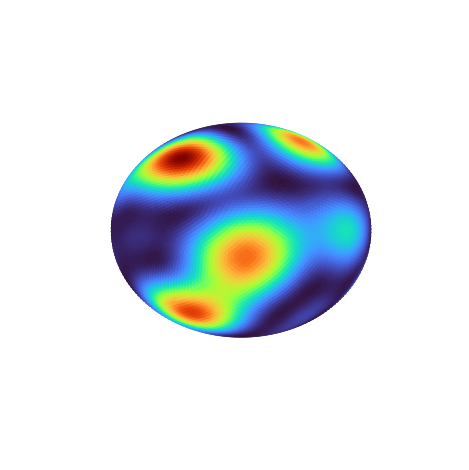

In [5]:
l_max = 8
n_coeffs = int(0.5 * (l_max + 1) * (l_max + 2))

odf_sh = np.array(
    [
        0.2819866,
        -0.05017412,
        -0.02567583,
        0.06072918,
        0.00454286,
        -0.08981515,
        0.08523956,
        -0.10345886,
        0.14002803,
        -0.02400726,
        0.00441382,
        -0.0734104,
        0.02493886,
        -0.05071812,
        0.03643094,
        -0.02358766,
        0.04934635,
        0.001587,
        0.00608412,
        0.12300456,
        -0.00352434,
        -0.0260295,
        0.00825021,
        -0.02386365,
        -0.01857504,
        -0.03697283,
        0.01739406,
        0.01180586,
        0.00430038,
        -0.03305486,
        0.01168234,
        -0.03618626,
        -0.00807854,
        -0.01720432,
        0.01868493,
        -0.03608433,
        -0.05661061,
        0.00211097,
        -0.02214772,
        0.00789058,
        -0.0339894,
        0.01285262,
        -0.00134089,
        0.03898313,
        0.00133444,
    ]
)

n_sides = 2**5
x, y, z = hp.pix2vec(n_sides, np.arange(12 * n_sides**2))
vertices = np.vstack((x, y, z)).T
thetas = np.arccos(vertices[:, 2])
phis = np.arctan2(vertices[:, 1], vertices[:, 0]) + np.pi
isft = np.zeros((len(vertices), n_coeffs))
for l in range(0, l_max + 1, 2):
    for m in range(-l, l + 1):
        isft[:, int(0.5 * l * (l + 1) + m)] = mmsim.sh(l, m, thetas, phis)
sft = np.linalg.inv(isft.T @ isft) @ isft.T

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    vertices[:, 0], vertices[:, 1], vertices[:, 2], c=isft @ odf_sh, cmap="turbo"
)
ax.set_axis_off()
fig.tight_layout()
plt.show()

## Simulation

Simulation requires a `Gradient` object, compartment signal fractions and diffusivities, and an ODF. Let's simulate data using a constrained 2-compartment model.

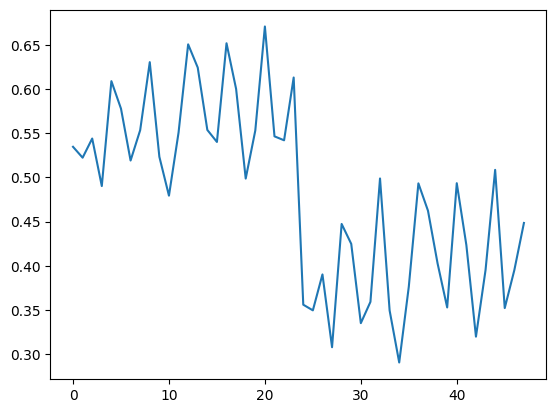

In [6]:
f = 0.8  # intra-neurite signal fraction
d = 2  # diffusivity

fs = np.array([f, 1 - f])
ads = np.array([d, d])
rds = np.array([0, (1 - f) * d])

signals = mmsim.compartment_model_simulation(gradient, fs, ads, rds, odf_sh)

plt.plot(signals)
plt.show()

## Validation

To check that the results are accurate, let's estimate what $d$ and $f$ were using SMT.

In [5]:
np.savetxt("dwi.bval", 1e3 * np.concatenate((np.zeros(1), bvals))[np.newaxis])
np.savetxt("dwi.bvec", np.vstack((np.zeros(3), bvecs)).T)
nib.save(
    nib.Nifti1Image(
        np.concatenate((np.ones(1), signals))[np.newaxis, np.newaxis, np.newaxis],
        np.eye(4),
    ),
    "dwi.nii.gz",
)
os.system(
    "./fitmcmicro --bvals dwi.bval --bvecs dwi.bvec dwi.nii.gz smt_results.nii.gz"
)  # this depends on a separate program

smt_results = nib.load("smt_results.nii.gz").get_fdata()

print(f"d = {d}")
print(f"d_hat = {1e3 * smt_results[0, 0, 0, 1]}")

print(f"f = {f}")
print(f"f_hat = {smt_results[0, 0, 0, 0]}")

d = 2
d_hat = 1.998684136196971
f = 0.8
f_hat = 0.8006992936134338


fitmcmicro .......... [==================================================] 100%
